In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/MAIN-PROJECT'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MAIN-PROJECT


In [2]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [3]:
IMAGE_SIZE = [224, 224] 

# training config:
epochs = 100
batch_size = 32

# path of dataset
covid_path = '/content/drive/MyDrive/MAIN-PROJECT/CT_COVID'
noncovid_path = '/content/drive/MyDrive/MAIN-PROJECT/CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [4]:
# Preparing Labels
# Images and Class Labels are Fetching from Files

covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('CT_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

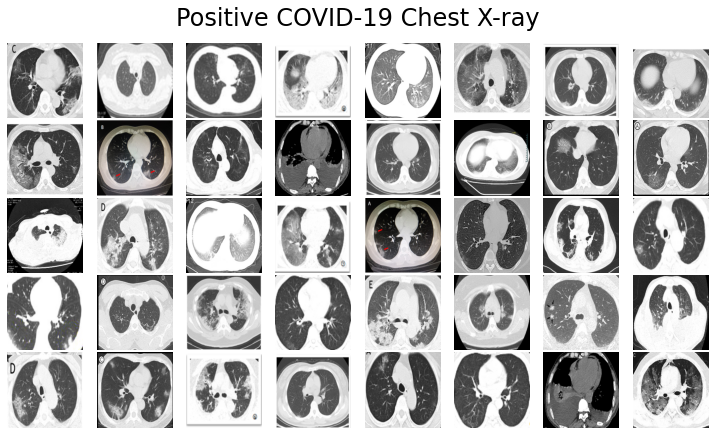

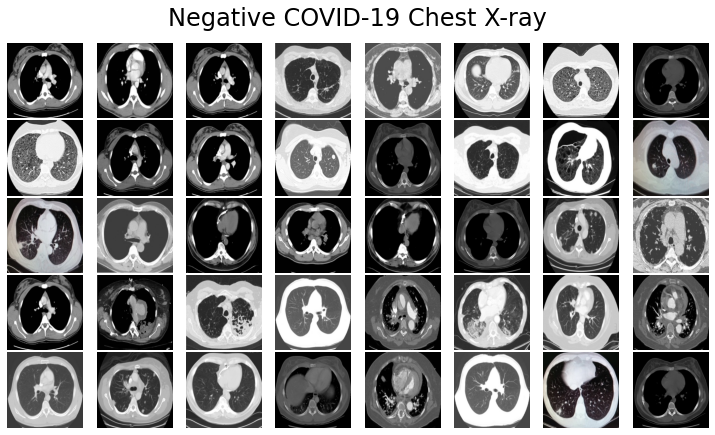

In [5]:
# Visualizing First 40 Images from Data set 

def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [6]:
# Normalization
# Model takes images in the form of array of pixels. Hence converting into array and normalize to interval of [0,1]

covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [7]:
#Train Test Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# spliting into training and testing

covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# makeing labels into categories - either 0 or 1

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)


In [8]:
# Building the model

mbnet = MobileNet(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = mbnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=mbnet.input, outputs=outputs)

for layer in mbnet.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)


# Image Augmentation
# To train on images at different positions, angles, flips, etc


train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [10]:
# Training the model

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=5)

Epoch 1/5
18/18 [==============================] - 33s 2s/step - loss: 3.6013 - accuracy: 0.6628 - val_loss: 3.8255 - val_accuracy: 0.6533
Epoch 2/5
18/18 [==============================] - 30s 2s/step - loss: 2.4163 - accuracy: 0.7164 - val_loss: 1.6987 - val_accuracy: 0.7800
Epoch 3/5
18/18 [==============================] - 30s 2s/step - loss: 1.6461 - accuracy: 0.7752 - val_loss: 2.0854 - val_accuracy: 0.7267
Epoch 4/5
18/18 [==============================] - 30s 2s/step - loss: 1.9351 - accuracy: 0.7970 - val_loss: 2.2739 - val_accuracy: 0.7267
Epoch 5/5
18/18 [==============================] - 31s 2s/step - loss: 1.6463 - accuracy: 0.8070 - val_loss: 2.2901 - val_accuracy: 0.7400


In [11]:
# Taking an image single

import cv2 

path='/content/drive/MyDrive/MAIN-PROJECT/CT_COVID/2020.02.25.20021568-p23-108%13.png'
image=cv2.imread(path)  
rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
imagetest = cv2.resize(rgb,(224,224))
imagetest = imagetest.reshape(1,224,224,3)

In [12]:
image4test = imagetest / 255

In [13]:
y_predTest = model.predict(image4test)

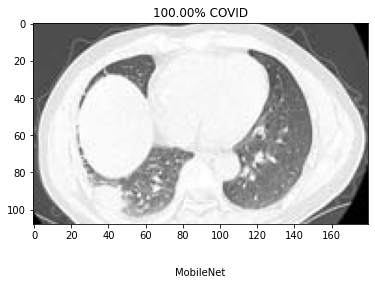

In [14]:
# Predicting the image class( Covid/NonCovid )

prediction=y_predTest
for probability in (prediction):
  if probability[0] > 0.5:
        plt.title('%.2f' % (probability[0]*100) + '% COVID')
        plt.xlabel('\n\nMobileNet')
  else:
        plt.title('%.2f' % ((1-probability[0])*100) + '% NonCOVID')
        plt.xlabel('\n\nMobileNet')
  plt.imshow(image)
  plt.show()

In [15]:
model.save('MobileNet_ct.h5')

In [16]:
model.save_weights('MobileNet_ct.hdf5')

In [17]:
model = load_model('MobileNet_ct.h5')

In [18]:
# Making Predicions

y_pred = model.predict(X_test, batch_size=batch_size)

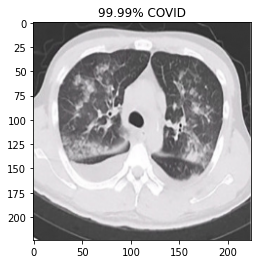

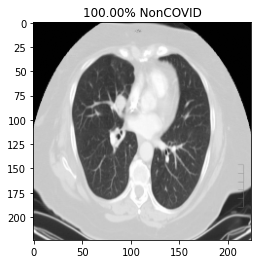

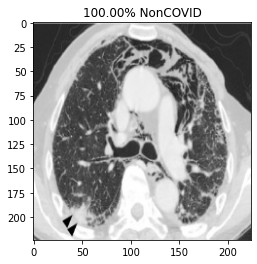

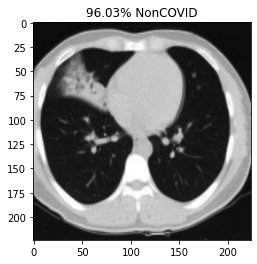

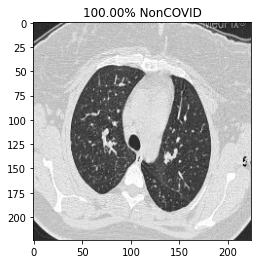

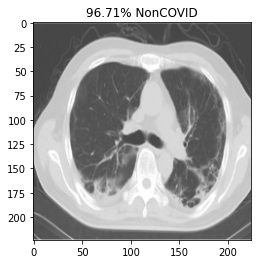

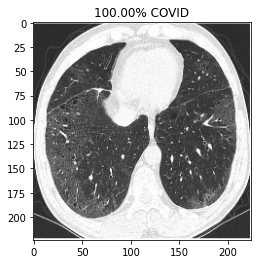

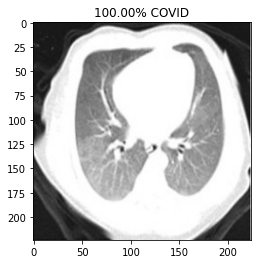

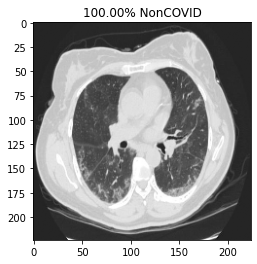

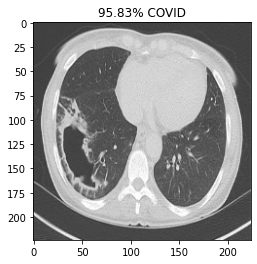

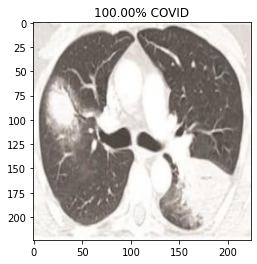

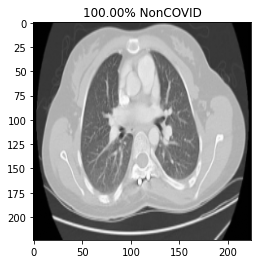

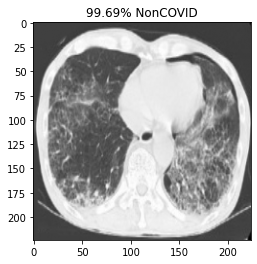

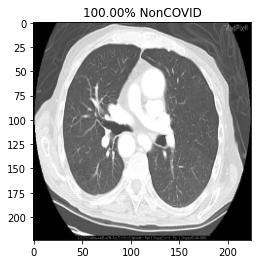

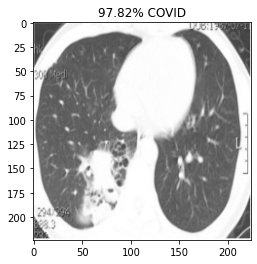

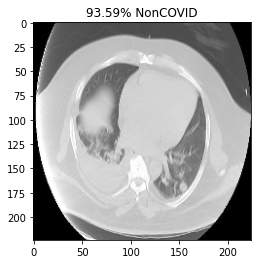

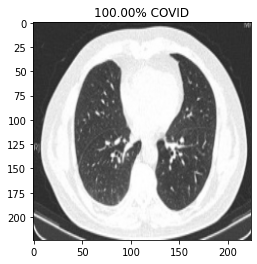

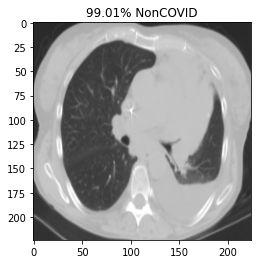

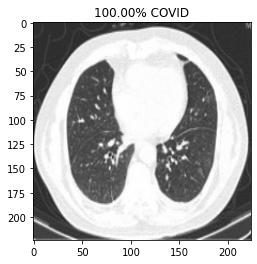

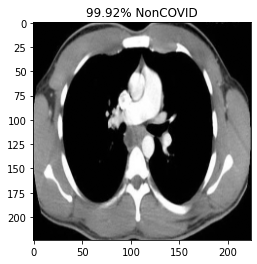

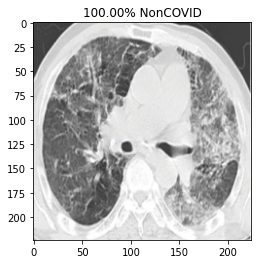

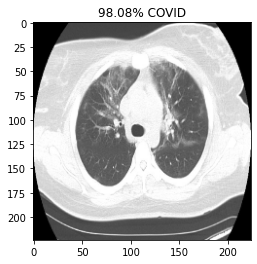

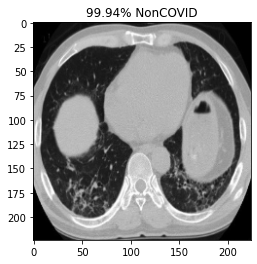

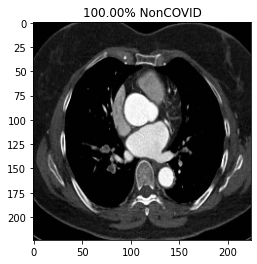

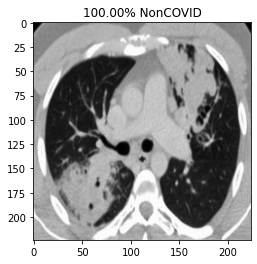

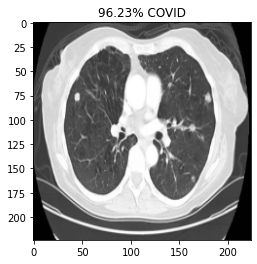

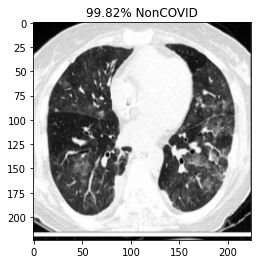

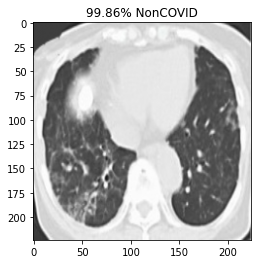

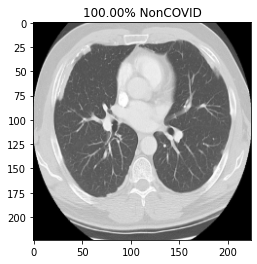

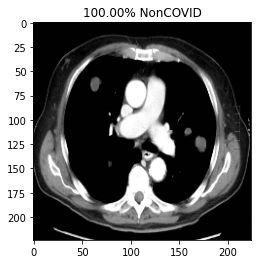

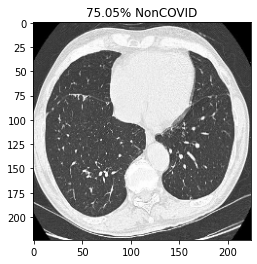

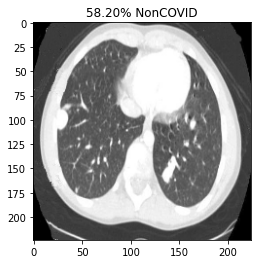

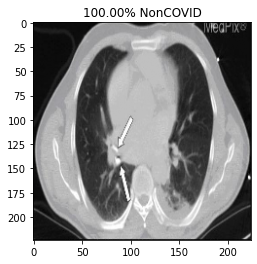

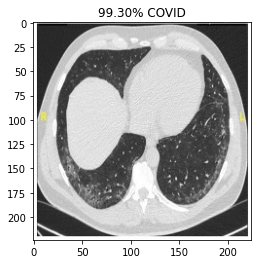

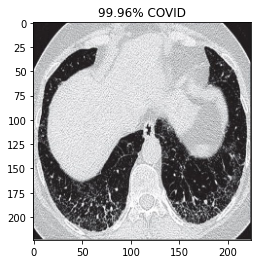

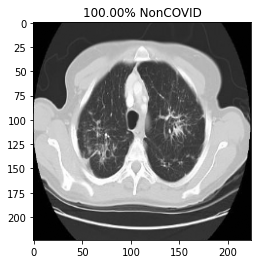

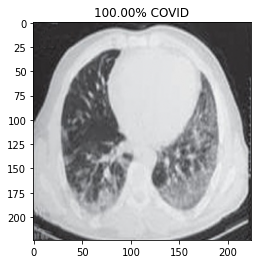

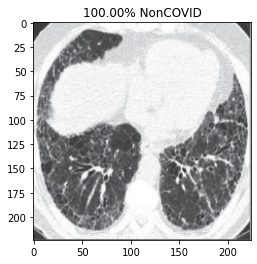

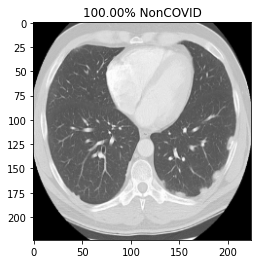

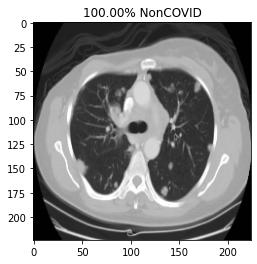

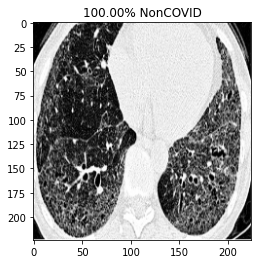

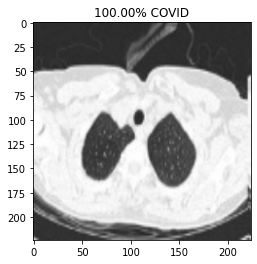

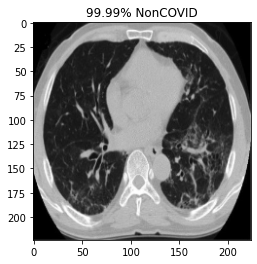

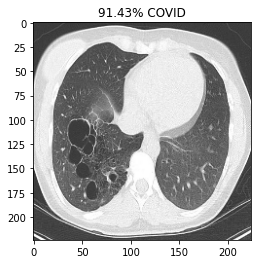

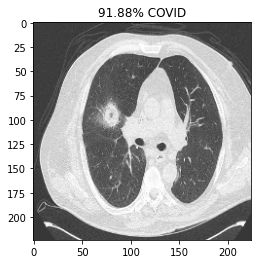

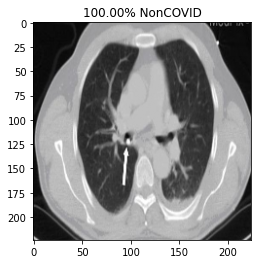

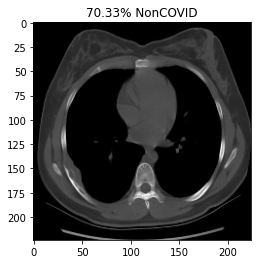

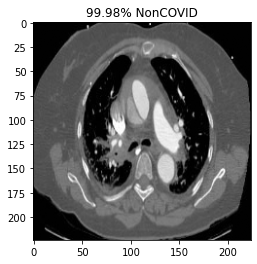

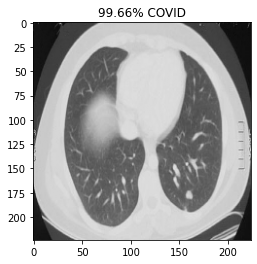

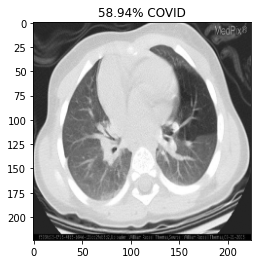

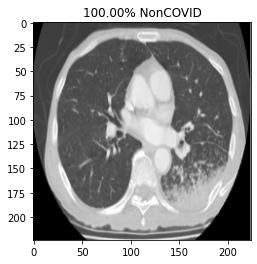

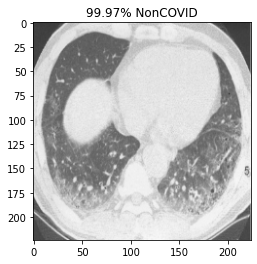

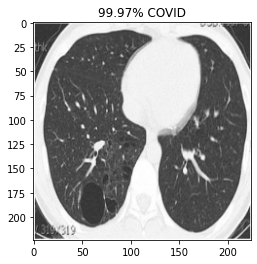

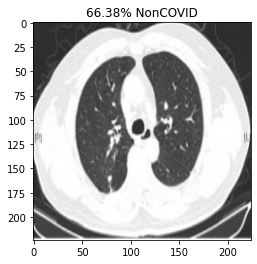

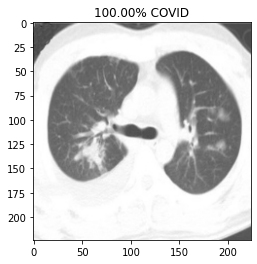

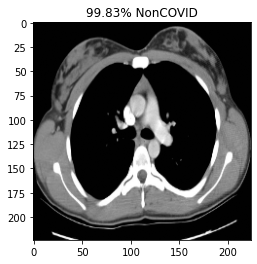

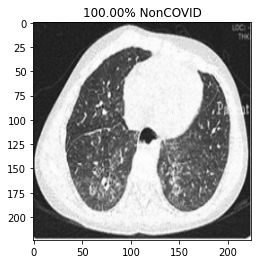

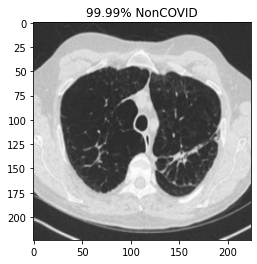

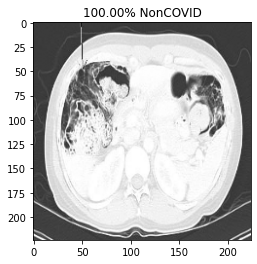

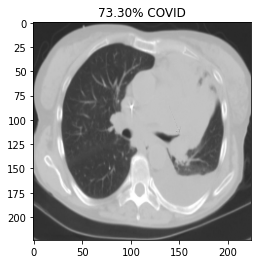

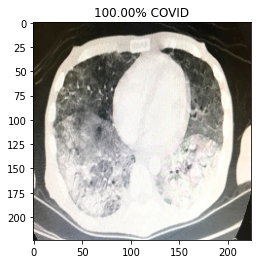

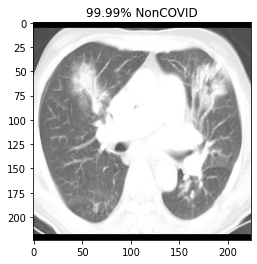

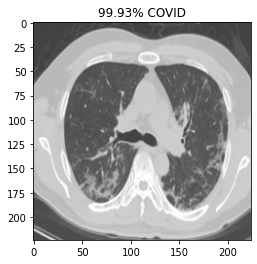

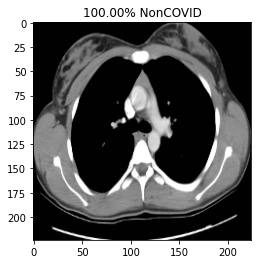

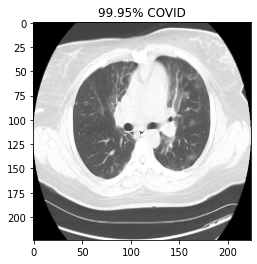

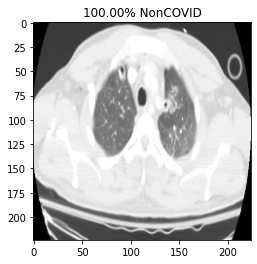

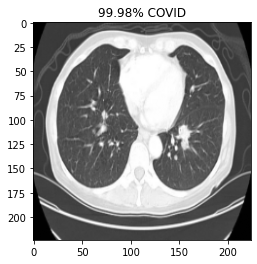

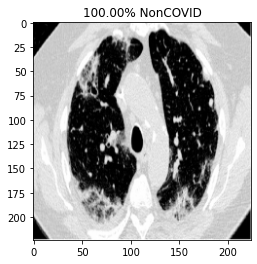

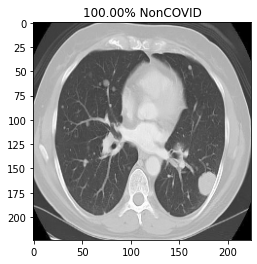

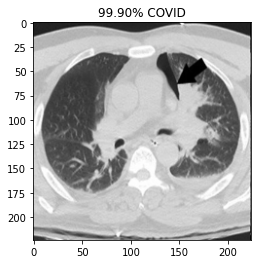

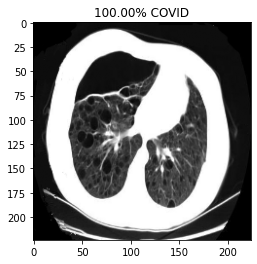

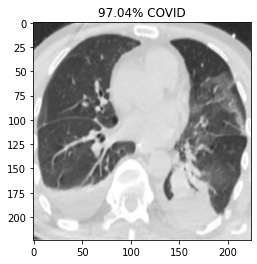

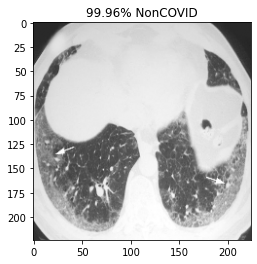

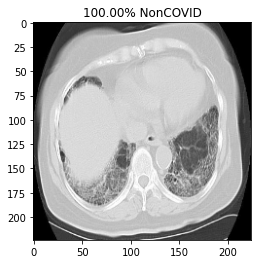

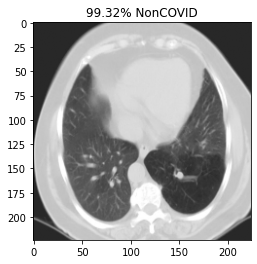

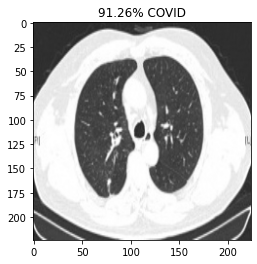

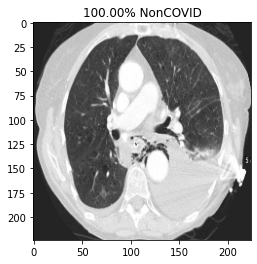

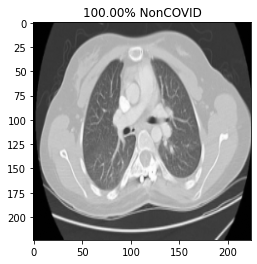

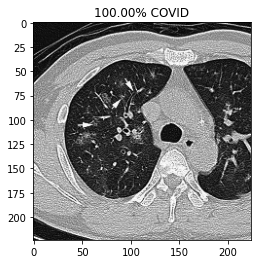

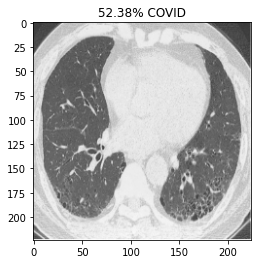

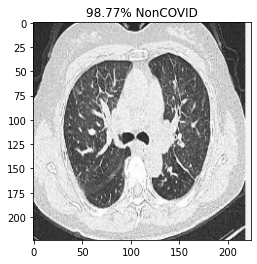

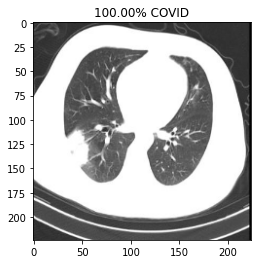

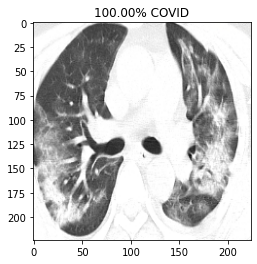

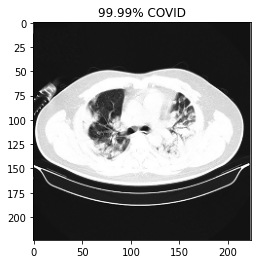

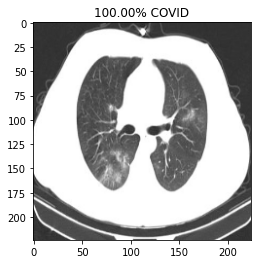

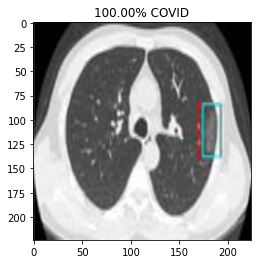

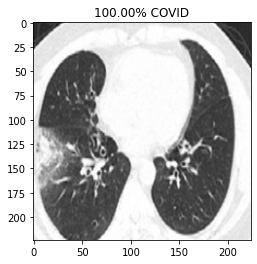

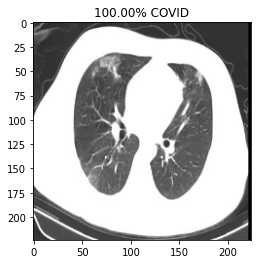

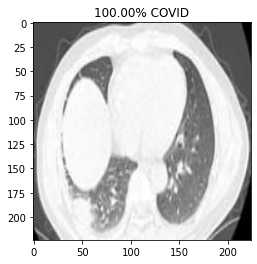

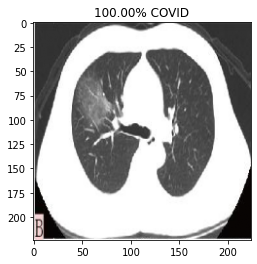

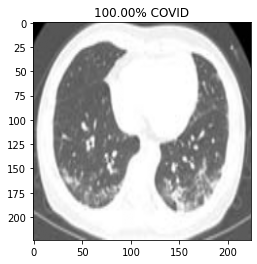

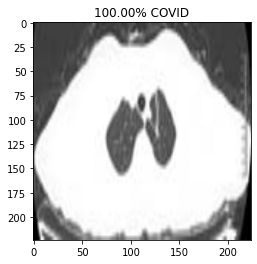

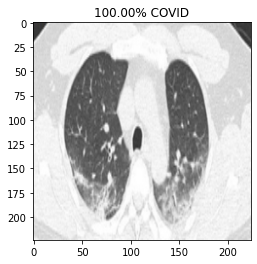

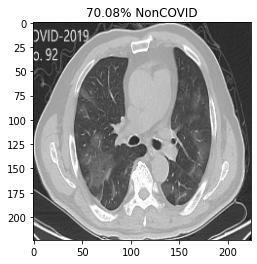

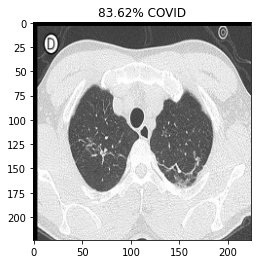

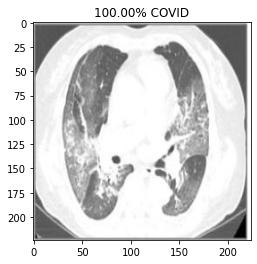

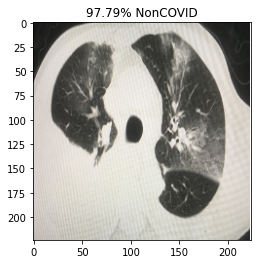

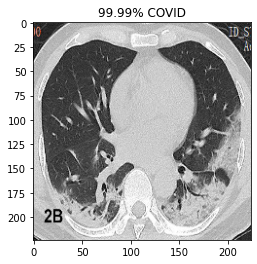

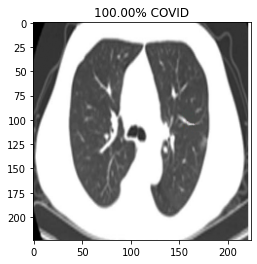

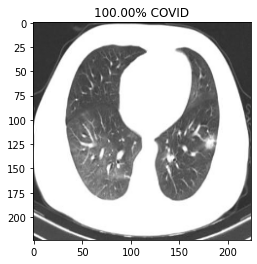

In [19]:
# Visulaizing First 100 predictions

prediction=y_pred[0:100]
for index, probability in enumerate(prediction):
  if probability[0] > 0.5:
        plt.title('%.2f' % (probability[0]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[0])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [20]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

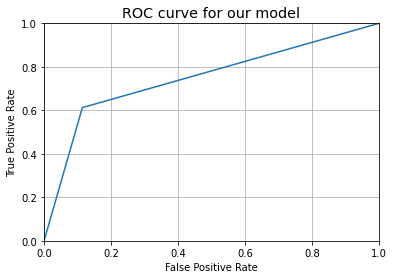

In [21]:
#ROC Curve

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

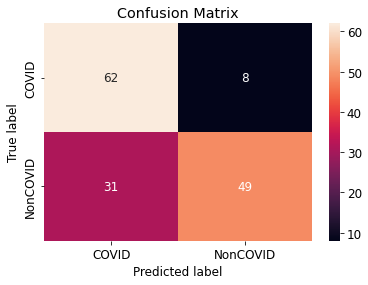

In [22]:
#Confusion Matrix

def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(normalize=None)

In [23]:
#Classification Report

from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76        70
           1       0.86      0.61      0.72        80

    accuracy                           0.74       150
   macro avg       0.76      0.75      0.74       150
weighted avg       0.77      0.74      0.74       150



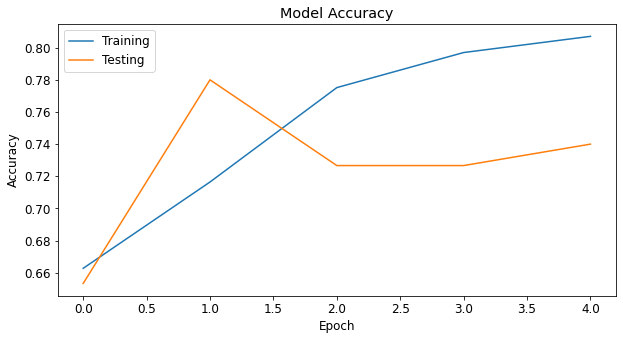

In [24]:
#Accuracy and Loss Plots

plt.figure(figsize=(10,5))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_accuracy.png')
plt.show()

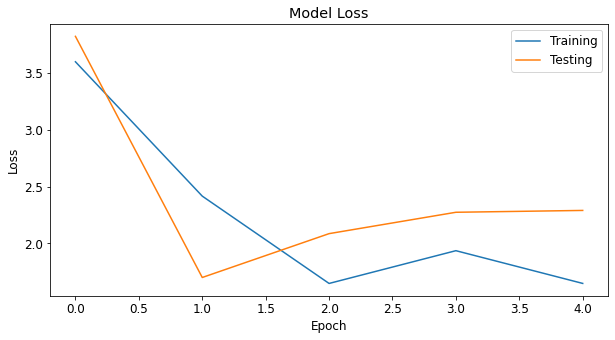

In [25]:
plt.figure(figsize=(10,5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_loss.png')
plt.show()